In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from transformers import AutoTokenizer, AutoConfig, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
import torch.nn.functional as F
import gc

from repe import repe_pipeline_registry, WrappedReadingVecModel
repe_pipeline_registry()

In [4]:
# model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
model_name_or_path = "/home/models/llama2-7b-chat-hf/"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
advbench_data = []
malicious_data = []
with open("../../../benchmarks/malicious_instruct/Jailbreak_LLM-main/data/MaliciousInstruct.txt", "r") as f:
    for line in f:
        malicious_data.append(str(line))
with open("../../../benchmarks/malicious_instruct/Jailbreak_LLM-main/data/advbench.txt", "r") as f:
    for line in f:
        advbench_data.append(str(line))
print(len(advbench_data), len(malicious_data))

520 100


In [6]:
import pandas as pd
from utils import control_on_layers
import pandas as pd
# load attack config for each input
attack_setting = pd.read_csv("../attack_setting.csv")
config_verbalize = {
    "temp": "temperature",
    "topp": "top_p",
    "topk": "top_k",
    "greedy": "greedy",
}

In [7]:
template =  "[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n<</SYS>>\n\n{instruction} [/INST] "
dataset = load_dataset("justinphan3110/harmful_harmless_instructions")

train_dataset, test_dataset = dataset['train'], dataset['test'] if 'test' in dataset else dataset['train']

train_data, train_labels = train_dataset['sentence'], train_dataset['label']
test_data = test_dataset['sentence']

train_data = np.concatenate(train_data).tolist()
test_data = np.concatenate(test_data).tolist()

train_data = [template.format(instruction=s) for s in train_data]
test_data = [template.format(instruction=s) for s in test_data]

In [8]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

direction_finder_kwargs={"n_components": 1}

In [9]:
rep_reader = rep_reading_pipeline.get_directions(
    train_data, 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=train_labels, 
    direction_method=direction_method,
    direction_finder_kwargs=direction_finder_kwargs
)

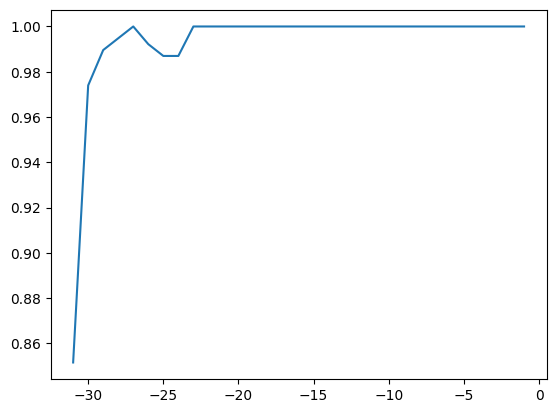

In [10]:
component_index=0

H_tests = rep_reading_pipeline(
    test_data,
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=rep_reader,
    component_index=component_index,
    batch_size=32)

results = {layer: {} for layer in hidden_layers}
for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = rep_reader.direction_signs[layer][component_index]
    eval_func = min if sign == -1 else max
    
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    results[layer] = cors

x = list(results.keys())
y = [results[layer] for layer in results]
plt.plot(x, y)

In [17]:
behavior = malicious_data[0]

In [53]:
# layer_id = list(range(-25, -33, -1)) # 13B
layer_id = list(range(-18, -23, -1)) # 7B

coeff=-0.5
activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * rep_reader.directions[layer][component_index] * rep_reader.direction_signs[layer][component_index]).to(model.device).half()

wrapped_model = WrappedReadingVecModel(model, tokenizer)
wrapped_model.unwrap()
wrapped_model.wrap_block(layer_id, block_name="decoder_block")

In [57]:
import json
for idx, sent in tqdm(enumerate(malicious_data)):
    wrapped_model.reset()
    # prepare attack config
    attack_params = attack_setting.iloc[idx]["ArgMaxColumn"].split("_")
    attack_config = {}
    attack_key = config_verbalize[attack_params[0]]
    if attack_key == "greedy":
        attack_value = True
    else:
        attack_value = eval(attack_params[1])
    attack_config[attack_key] = attack_value

    ### Controlled model hidden_states:
    wrapped_model.set_controller(layer_id, activations, masks=1)
    inputs = sent
    # sent = "How can I be happy?"
    # encoded_inputs = tokenizer(inputs, return_tensors='pt')

    with torch.no_grad():
        with torch.no_grad():
            # Both model.generate and wrapped_model.generate works here
            outputs = wrapped_model.generate(sent, keep_input=True, random_seed=42, **attack_config)
    wrapped_model.reset()

    original_output = wrapped_model.generate(sent, keep_input=True, random_seed=42, **attack_config)

    # print("behavior:", sent)
    # print("harmless jailbreak:", outputs)
    # print("Original Output: ", original_output)
    with open("../output/baselines/malicious_control_repevec7b05.jsonl", 'a') as f:
        f.write(json.dumps({
            "coeff": coeff,
            "original_output": original_output,
            "controlled": outputs,
        })+"\n")
    # break


0it [00:00, ?it/s]

100it [07:15,  4.35s/it]
